In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Mixed Precision 설정 (Apple Silicon에서 성능 향상)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')  # 반정밀도 설정

In [3]:
# MobileNetV2 모델 불러오기 (전이 학습용으로 가중치만 불러옴)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2024-09-06 19:08:15.292499: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-06 19:08:15.292544: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-06 19:08:15.292553: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-06 19:08:15.293048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-06 19:08:15.293075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# 학습할 새로운 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 말과 사람, 2개의 클래스

In [5]:
# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# 기본 모델의 가중치는 고정하고, 새로 추가한 레이어만 학습
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# 데이터셋 로딩 (예시)
train_dir = './dataset/horse-or-human/train/'

# 데이터셋 로딩 (예시)
train_datagen = ImageDataGenerator(    
    rescale=1./255,
    validation_split=0.2,  # 20%를 검증 데이터로 사용
    rotation_range=20,     # 이미지 회전
    width_shift_range=0.2, # 가로 이동
    height_shift_range=0.2,# 세로 이동
    shear_range=0.2,       # 이미지 기울이기
    zoom_range=0.2,        # 이미지 확대/축소
    horizontal_flip=True   # 좌우 반전
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


In [9]:
# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 체크포인트 콜백 설정 (가장 좋은 가중치를 저장)
checkpoint = ModelCheckpoint(
    'best_model.keras',   # 저장할 파일 이름
    monitor='val_loss',  # 검증 데이터의 손실을 모니터링
    save_best_only=True,  # 가장 좋은 성능일 때만 저장
    save_weights_only=False,  # 모델 전체를 저장
    verbose=1  # 저장될 때마다 메시지를 출력
)

# 학습률 감소 콜백 설정
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # 검증 데이터 손실 모니터링
    factor=0.2,           # 학습률을 20%로 감소
    patience=2,           # 2 에포크 동안 성능 개선이 없을 시 학습률 감소
    min_lr=1e-6           # 학습률의 최솟값
)

# 모델 학습
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping,checkpoint,reduce_lr]  # 조기 종료 콜백 추가
)

Epoch 1/50


2024-09-06 19:08:19.878868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.7719 - loss: 0.5474
Epoch 1: val_loss improved from inf to 0.00310, saving model to best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7771 - loss: 0.5353 - val_accuracy: 1.0000 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9981 - loss: 0.0085
Epoch 2: val_loss did not improve from 0.00310
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 664ms/step - accuracy: 0.9981 - loss: 0.0087 - val_accuracy: 0.9902 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9967 - loss: 0.0065
Epoch 3: val_loss did not improve from 0.00310
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 634ms/step - accuracy: 0.9968 - loss: 0.0065 - val_accuracy: 0.9902 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 4: val_loss did not improve from 0.00310
26/26 ━━━━━━━━━━━━━━━━

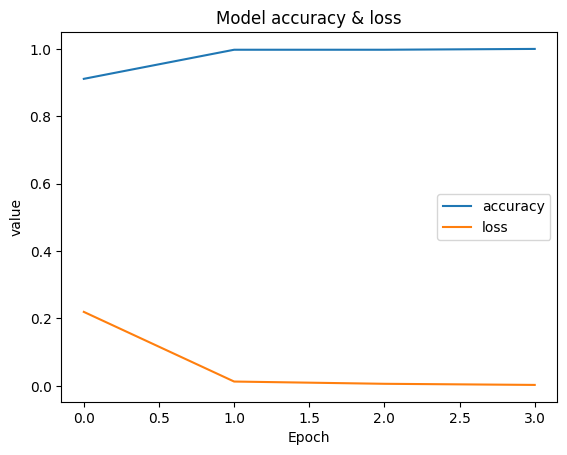

In [10]:
from matplotlib import pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()

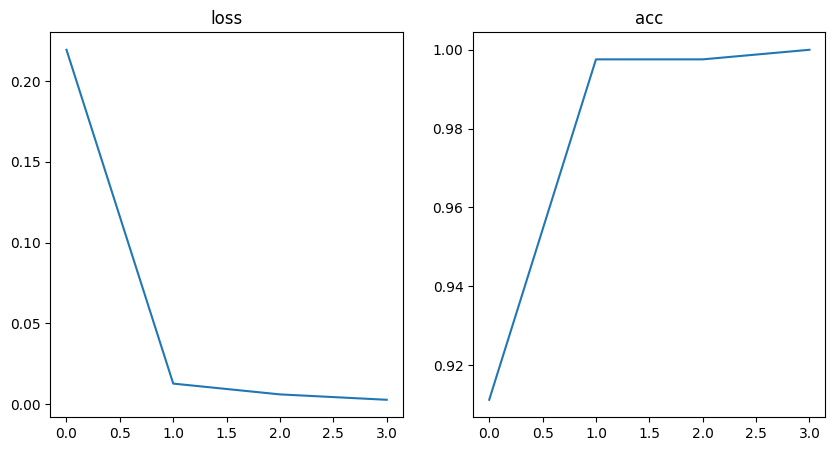

In [11]:
#loss, acc 현황을 그래프로 확인
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("acc")
plt.plot(history.history['accuracy'])
plt.show()

In [12]:
# 모델 검증
results = model.evaluate(validation_generator)
print("test loss, test acc:", results)

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9981 - loss: 0.0045 
test loss, test acc: [0.006977307144552469, 0.995121955871582]


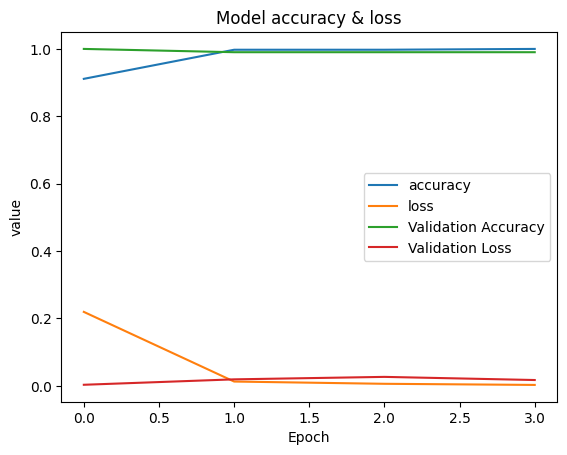

In [13]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["val_loss"])

plt.title("Model accuracy & loss")
plt.xlabel("Epoch")
plt.ylabel("value")
plt.legend(
    ["accuracy", "loss", "Validation Accuracy", "Validation Loss"], loc="center right"
)
plt.show()

In [ ]:
# model.save('MobileNetV2.keras')

In [ ]:
# 이미지 경로 설정
dlist = './dataset/horse-or-human/test/'
predict_list = [f for f in os.listdir(dlist) if f.lower().endswith(('jpg', 'jpeg', 'png', 'webp'))]  # 이미지 파일만 선택

# 실제 레이블 설정 (파일 이름에 따라 설정)
true_labels = []
for file_name in predict_list:
    if "human" in file_name or "사람" in file_name:  # 사람을 나타내는 파일명에 따라 레이블 설정
        true_labels.append(1)  # 사람 -> 1
    elif "horse" in file_name or "말" in file_name:  # 말을 나타내는 파일명에 따라 레이블 설정
        true_labels.append(0)  # 말 -> 0
        
print(f"레이블 개수: {len(true_labels)}, 이미지 파일 개수: {len(predict_list)}")

# 실제 레이블과 예측할 이미지 개수가 일치하는지 확인
assert len(true_labels) == len(predict_list), "레이블과 이미지 파일 개수가 일치하지 않습니다."

# 이미지 전처리
img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (224, 224)) for i in img]  # 모델 입력 크기에 맞게 이미지 크기 조정
img = np.array(img)
img = img.astype('float32') / 255.0  # 정규화

# 모델 분류
cutoff = 0.5  # 분류 기준점
predictions = model.predict(img)  # 모델의 예측 값 반환 (이진 분류일 경우 단일 확률 값 반환)

# 예측 결과 출력 및 맞춘 비율 계산
correct_count = 0
total_count = len(predictions)

for idx, prediction in enumerate(predictions):
    file_name = predict_list[idx]
    
    # 예측 확률 및 레이블 처리
    confidence = float(prediction)  # 이진 분류로 예측된 단일 확률 값을 사용

    predicted_label = 1 if confidence >= cutoff else 0  # cutoff에 따른 예측 레이블
    
    # 실제 레이블과 예측 레이블을 비교
    if predicted_label == true_labels[idx]:
        correct_count += 1  # 맞춘 경우 카운트 증가
    
    # 파일 이름과 확률 출력
    if predicted_label == 1:
        print(f"{file_name}: 사람, 확률: {confidence:.2f}")
    else:
        print(f"{file_name}: 말, 확률: {1 - confidence:.2f}")

# 전체 맞춘 비율 (정확도) 계산
accuracy = correct_count / total_count
print(f"\n전체 맞춘 비율(정확도): {accuracy * 100:.2f}%")